In [61]:
import warnings
warnings.simplefilter("ignore")

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#  Start a Spark session with Hive support
spark = SparkSession.builder \
    .appName("HiveToPandas") \
    .enableHiveSupport() \
    .getOrCreate()

In [3]:
#  Define the Hive table name
hive_table = "flight_db.flight_data_partitioned_month"

#  Read the Hive table into a Spark DataFrame
df_spark = spark.sql(f"SELECT * FROM {hive_table}")

In [5]:
df_spark.count()

5601139

## Samplimg

In [11]:
# Get the unique months available in the data
months = df_spark.select("Month").distinct().collect()
print(months)
# Sample 5% data for each month
df_monthly_sampled = None

for month in months:
    month_data = df_spark.filter(df_spark.Month == month["Month"]) \
                         .sample(withReplacement=False, fraction=0.05, seed=1234)
    
    # Union the monthly sampled data
    if df_monthly_sampled is None:
        df_monthly_sampled = month_data
    else:
        df_monthly_sampled = df_monthly_sampled.union(month_data)

# Show the first 5 rows of the sampled data
df_monthly_sampled.show(5)


[Row(Month='7'), Row(Month='11'), Row(Month='3'), Row(Month='8'), Row(Month='5'), Row(Month='6'), Row(Month='9'), Row(Month='1'), Row(Month='10'), Row(Month='4'), Row(Month='12'), Row(Month='2')]
+----+-------+----------+---------+----------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+---------------+------------------+------------------+------+---------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----+---------------+---------+-------------+-------------+-------+----------+-------+--------+---------------+--------+--------------------+----------+-------+---------+--------+------+----------+-------+--------+---------------+--------+------------------+----------+---------+--------+--------------+-----------------+----

In [12]:
df_monthly_sampled.count()

280936

In [13]:
df_monthly_sampled.describe

<bound method DataFrame.describe of DataFrame[Year: string, Quarter: string, DayofMonth: string, DayOfWeek: string, FlightDate: string, Marketing_Airline_Network: string, Operated_or_Branded_Code_Share_Partners: string, DOT_ID_Marketing_Airline: string, IATA_Code_Marketing_Airline: string, Flight_Number_Marketing_Airline: string, Operating_Airline: string, DOT_ID_Operating_Airline: string, IATA_Code_Operating_Airline: string, Flight_Number_Operating_Airline: string, OriginAirportID: string, OriginAirportSeqID: string, OriginCityMarketID: string, Origin: string, OriginCityName: string, OriginState: string, OriginStateFips: string, OriginStateName: string, OriginWac: string, DestAirportID: string, DestAirportSeqID: string, DestCityMarketID: string, Dest: string, DestCityName: string, DestState: string, DestStateFips: string, DestStateName: string, DestWac: string, CRSDepTime: string, DepTime: string, DepDelay: double, DepDelayMinutes: double, DepDel15: double, DepartureDelayGroups: doubl

In [25]:
from pyspark.sql import functions as F

# Group by 'Origin' and 'Dest' to calculate total delayed flights
route_delays = df_monthly_sampled.groupBy("OriginCityName", "DestCityName").agg(
    F.sum("DepDel15").alias("total_delayed_flights_dep"),
    F.sum("ArrDel15").alias("total_delayed_flights_arr")
)

# Sort by total delayed flights at departure in descending order
route_delays_sorted = route_delays.orderBy(F.desc("total_delayed_flights_dep"))

# Show the top 10 routes with the most delayed flights
route_delays_sorted.show(10)

+-------------------+-----------------+-------------------------+-------------------------+
|     OriginCityName|     DestCityName|total_delayed_flights_dep|total_delayed_flights_arr|
+-------------------+-----------------+-------------------------+-------------------------+
|        Chicago, IL|     New York, NY|                    192.0|                    215.0|
|    Los Angeles, CA|San Francisco, CA|                    139.0|                    154.0|
|       New York, NY|      Chicago, IL|                    131.0|                    168.0|
|  San Francisco, CA|  Los Angeles, CA|                    130.0|                    173.0|
|         Boston, MA|     New York, NY|                    123.0|                    124.0|
|      San Diego, CA|San Francisco, CA|                    108.0|                    114.0|
|       New York, NY|       Boston, MA|                    106.0|                    108.0|
|Fort Lauderdale, FL|       Newark, NJ|                    106.0|               

In [27]:
# Group by 'Origin' and calculate the average departure and arrival delays
origin_efficiency = df_monthly_sampled.groupBy("OriginCityName").agg(
     F.round(F.avg("DepDelay"),2).alias("avg_dep_delay"),
     F.round(F.avg("ArrDelay"),2).alias("avg_arr_delay")
)

# Sort by average departure delay (ascending) to identify efficient airports
origin_efficiency_sorted = origin_efficiency.orderBy(F.asc("avg_dep_delay"))

# Display the 5 most efficient airports (lowest departure delay)
print("Most Efficient Airports:")
origin_efficiency_sorted.show(5)

# Display the 5 least efficient airports (highest departure delay)
print("Least Efficient Airports:")
origin_efficiency_sorted.orderBy(F.desc("avg_dep_delay")).show(5)


Most Efficient Airports:
+--------------+-------------+-------------+
|OriginCityName|avg_dep_delay|avg_arr_delay|
+--------------+-------------+-------------+
|   Yakutat, AK|       -15.24|        -11.1|
|  Gustavus, AK|       -14.67|       -15.67|
|  Wrangell, AK|       -13.97|       -11.97|
| Deadhorse, AK|       -13.36|       -17.19|
|    Barrow, AK|       -10.32|       -12.93|
+--------------+-------------+-------------+
only showing top 5 rows

Least Efficient Airports:
+--------------------+-------------+-------------+
|      OriginCityName|avg_dep_delay|avg_arr_delay|
+--------------------+-------------+-------------+
|       Owensboro, KY|        193.8|        194.0|
|         Hyannis, MA|         79.0|        76.25|
|Clarksburg/Fairmo...|        66.56|        64.69|
|     Plattsburgh, NY|         51.4|        47.04|
|Presque Isle/Houl...|        42.19|        31.86|
+--------------------+-------------+-------------+
only showing top 5 rows



In [37]:
# Group by 'Origin' and count the number of flights for each airport
airport_flight_count = df_monthly_sampled.groupBy("OriginCityName").count().alias("flight_count")

# Sort by flight count in descending order to find the busiest airport
airport_flight_count_sorted = airport_flight_count.orderBy(F.desc("count"))

# Display the busiest airport
print("Busiest Origin Airport:")
airport_flight_count_sorted.show(1)


Busiest Origin Airport:
+--------------+-----+
|OriginCityName|count|
+--------------+-----+
|   Chicago, IL|18402|
+--------------+-----+
only showing top 1 row



## Busiest Destination Airport

In [35]:
# Group by 'Dest' and count the number of flights for each destination
dest_flight_count = df_monthly_sampled.groupBy("DestCityName").count().alias("flight_count")

# Sort by flight count in descending order to find the busiest destination airport
dest_flight_count_sorted = dest_flight_count.orderBy(F.desc("count"))

# Display the busiest destination airport
print("Busiest Destination Airport:")
dest_flight_count_sorted.show(1)


Busiest Destination Airport:
+------------+-----+
|DestCityName|count|
+------------+-----+
| Chicago, IL|18307|
+------------+-----+
only showing top 1 row



 ## Airline with the Most Flights

In [38]:
# Group by 'Marketing_Airline_Network' and count the flights for each airline
airline_flight_count = df_monthly_sampled.groupBy("Marketing_Airline_Network").count()

# Sort by flight count in descending order
airline_flight_count_sorted = airline_flight_count.orderBy(F.desc("count"))

# Display the airline with the most flights
print("Airline with the Most Flights:")
airline_flight_count_sorted.show(1)


Airline with the Most Flights:
+-------------------------+-----+
|Marketing_Airline_Network|count|
+-------------------------+-----+
|                       UA|75075|
+-------------------------+-----+
only showing top 1 row



## Average Flight Delay per Airline

In [39]:
# Group by airline and calculate average departure and arrival delays (rounded)
airline_delays = df_monthly_sampled.groupBy("Marketing_Airline_Network").agg(
    F.round(F.avg("DepDelay"), 2).alias("avg_dep_delay"),
    F.round(F.avg("ArrDelay"), 2).alias("avg_arr_delay")
)

# Sort by average departure delay to find best/worst-performing airlines
airline_delays_sorted = airline_delays.orderBy(F.asc("avg_dep_delay"))

# Display the top 5 most punctual airlines
print("Most Punctual Airlines:")
airline_delays_sorted.show(5)

# Display the top 5 most delayed airlines
print("Most Delayed Airlines:")
airline_delays_sorted.orderBy(F.desc("avg_dep_delay")).show(5)


Most Punctual Airlines:
+-------------------------+-------------+-------------+
|Marketing_Airline_Network|avg_dep_delay|avg_arr_delay|
+-------------------------+-------------+-------------+
|                       HA|         1.75|         1.81|
|                       AS|         2.46|        -0.31|
|                       VX|         4.05|        -0.62|
|                       DL|         7.92|         0.95|
|                       AA|         9.76|         6.48|
+-------------------------+-------------+-------------+
only showing top 5 rows

Most Delayed Airlines:
+-------------------------+-------------+-------------+
|Marketing_Airline_Network|avg_dep_delay|avg_arr_delay|
+-------------------------+-------------+-------------+
|                       F9|        18.82|        13.37|
|                       B6|        16.13|        11.66|
|                       G4|        12.91|         9.65|
|                       WN|        11.06|         4.38|
|                       UA|     

## Best & Worst Performing Routes (Based on Delays)

In [40]:
# Group by route (Origin-Dest) and compute average delay
route_delays = df_monthly_sampled.groupBy("OriginCityName", "DestCityName").agg(
    F.round(F.avg("DepDelay"), 2).alias("avg_dep_delay"),
    F.round(F.avg("ArrDelay"), 2).alias("avg_arr_delay")
)

# Sort by departure delay to find the best and worst routes
best_routes = route_delays.orderBy(F.asc("avg_dep_delay"))
worst_routes = route_delays.orderBy(F.desc("avg_dep_delay"))

# Display best (least delayed) and worst (most delayed) routes
print("Best Routes (Least Delayed):")
best_routes.show(5)

print("Worst Routes (Most Delayed):")
worst_routes.show(5)


Best Routes (Least Delayed):
+------------------+------------------+-------------+-------------+
|    OriginCityName|      DestCityName|avg_dep_delay|avg_arr_delay|
+------------------+------------------+-------------+-------------+
|Montrose/Delta, CO|        Newark, NJ|        -21.0|        -32.0|
|        Dayton, OH|  Myrtle Beach, SC|        -21.0|        -18.0|
|        Hayden, CO|     San Diego, CA|        -21.0|        -41.0|
|        Albany, NY|St. Petersburg, FL|        -19.0|         -6.0|
|       Yakutat, AK|        Juneau, AK|       -18.78|       -12.22|
+------------------+------------------+-------------+-------------+
only showing top 5 rows

Worst Routes (Most Delayed):
+---------------+--------------------+-------------+-------------+
| OriginCityName|        DestCityName|avg_dep_delay|avg_arr_delay|
+---------------+--------------------+-------------+-------------+
| Harrisburg, PA|    White Plains, NY|        759.0|        798.0|
|New Orleans, LA|   Atlantic City, NJ

## Delay Trends by Day of the Week

In [41]:
# Group by DayOfWeek and calculate average delays
daywise_delays = df_monthly_sampled.groupBy("DayOfWeek").agg(
    F.round(F.avg("DepDelay"), 2).alias("avg_dep_delay"),
    F.round(F.avg("ArrDelay"), 2).alias("avg_arr_delay")
)

# Sort by day of the week
daywise_delays_sorted = daywise_delays.orderBy("DayOfWeek")

# Display the delay trend by day of the week
print("Flight Delays by Day of the Week:")
daywise_delays_sorted.show()


Flight Delays by Day of the Week:
+---------+-------------+-------------+
|DayOfWeek|avg_dep_delay|avg_arr_delay|
+---------+-------------+-------------+
|        1|        10.94|         6.23|
|        2|         9.89|         5.12|
|        3|         8.87|         4.26|
|        4|        11.21|         7.04|
|        5|         11.9|         7.75|
|        6|         7.67|         1.85|
|        7|          9.7|         4.35|
+---------+-------------+-------------+



## Delay Trends by Time of Day

In [42]:
# Group by departure time block and calculate average delays
timewise_delays = df_monthly_sampled.groupBy("DepTimeBlk").agg(
    F.round(F.avg("DepDelay"), 2).alias("avg_dep_delay"),
    F.round(F.avg("ArrDelay"), 2).alias("avg_arr_delay")
)

# Sort by time block
timewise_delays_sorted = timewise_delays.orderBy("DepTimeBlk")

# Display the delay trend by time of day
print("Flight Delays by Time of Day:")
timewise_delays_sorted.show()


Flight Delays by Time of Day:
+----------+-------------+-------------+
|DepTimeBlk|avg_dep_delay|avg_arr_delay|
+----------+-------------+-------------+
| 0001-0559|         2.73|         -2.8|
| 0600-0659|         2.64|        -1.86|
| 0700-0759|         3.05|        -1.28|
| 0800-0859|         4.38|        -0.09|
| 0900-0959|         5.72|         1.02|
| 1000-1059|         6.96|         2.38|
| 1100-1159|         8.44|         3.31|
| 1200-1259|         9.74|         5.07|
| 1300-1359|        10.71|         6.07|
| 1400-1459|        12.38|         7.93|
| 1500-1559|        11.88|          7.1|
| 1600-1659|         14.2|         9.77|
| 1700-1759|         15.4|        11.04|
| 1800-1859|        16.69|         12.3|
| 1900-1959|        16.78|        11.36|
| 2000-2059|        16.69|        11.13|
| 2100-2159|        14.76|         9.08|
| 2200-2259|        13.78|         8.04|
| 2300-2359|        10.58|         3.91|
+----------+-------------+-------------+



## Longest & Shortest Flights (By Distance)

In [48]:
# Sort flights by distance
longest_flights = df_monthly_sampled.orderBy(F.desc("Distance"))
shortest_flights = df_monthly_sampled.orderBy(F.asc("Distance"))

# Display the longest and shortest flights
print("Longest Flights in Miles:")
longest_flights.select("OriginCityName", "DestCityName", "Distance").show(5)

print("Shortest Flights in Miles:")
shortest_flights.select("OriginCityName", "DestCityName", "Distance").show(5)


Longest Flights in Miles:
+--------------------+--------------------+--------+
|      OriginCityName|        DestCityName|Distance|
+--------------------+--------------------+--------+
|Dallas/Fort Worth...|Greensboro/High P...|  999.00|
|  Salt Lake City, UT|          Dallas, TX|  999.00|
|     Punta Gorda, FL|       Cleveland, OH|  999.00|
|          Dallas, TX|  Salt Lake City, UT|  999.00|
|  Salt Lake City, UT|          Dallas, TX|  999.00|
+--------------------+--------------------+--------+
only showing top 5 rows

Shortest Flights in Miles:
+--------------+------------+--------+
|OriginCityName|DestCityName|Distance|
+--------------+------------+--------+
|  Honolulu, HI| Kahului, HI|  100.00|
|  Honolulu, HI| Kahului, HI|  100.00|
|  Honolulu, HI| Kahului, HI|  100.00|
|  Honolulu, HI| Kahului, HI|  100.00|
|  Honolulu, HI| Kahului, HI|  100.00|
+--------------+------------+--------+
only showing top 5 rows



##  Most Reliable & Unreliable Routes Based on Delay Probability

In [52]:
# Group by route (Origin-Dest) and calculate delay probability
route_delay_probability = df_monthly_sampled.groupBy("OriginCityName", "DestCityName").agg(
    (F.sum(F.when(F.col("DepDel15") == 1, 1).otherwise(0)) / F.count("*")).alias("delay_probability")
)

# Sort routes by delay probability
most_reliable_routes = route_delay_probability.orderBy(F.asc("delay_probability"))
most_unreliable_routes = route_delay_probability.orderBy(F.desc("delay_probability"))

# Display best and worst routes based on delay probability
print("Most Reliable Routes (Lowest Delay Probability):")
most_reliable_routes.show(5)

print("Most Unreliable Routes (Highest Delay Probability):")
most_unreliable_routes.show(5)


Most Reliable Routes (Lowest Delay Probability):
+----------------+--------------+-----------------+
|  OriginCityName|  DestCityName|delay_probability|
+----------------+--------------+-----------------+
|Myrtle Beach, SC|Harrisburg, PA|              0.0|
|    Columbia, SC|   Houston, TX|              0.0|
|Fayetteville, AR| Las Vegas, NV|              0.0|
| Minneapolis, MN| Kalispell, MT|              0.0|
|  Rapid City, SD|   Phoenix, AZ|              0.0|
+----------------+--------------+-----------------+
only showing top 5 rows

Most Unreliable Routes (Highest Delay Probability):
+--------------------+------------+-----------------+
|      OriginCityName|DestCityName|delay_probability|
+--------------------+------------+-----------------+
|Dallas/Fort Worth...|Cheyenne, WY|              1.0|
|           Eagle, CO| Phoenix, AZ|              1.0|
|           Tampa, FL|Syracuse, NY|              1.0|
| Fort Lauderdale, FL| Trenton, NJ|              1.0|
|         Sanford, FL|   Oma

 ## Most Efficient & Inefficient Airports Based on Time Wasted

In [64]:
# Group by airport and calculate total time wasted due to departure delays
airport_efficiency = df_monthly_sampled.groupBy("OriginCityName").agg(
    F.sum("DepDelay").alias("total_time_wasted")
)

# Sort airports by least and most time wasted
most_efficient_airports = airport_efficiency.orderBy(F.asc("total_time_wasted"))
least_efficient_airports = airport_efficiency.orderBy(F.desc("total_time_wasted"))

# Display the most and least efficient airports
print("Most Efficient Airports (Least Time Wasted):")
most_efficient_airports.show(5)

print("Least Efficient Airports (Most Time Wasted):")
least_efficient_airports.show(5)


Most Efficient Airports (Least Time Wasted):
+--------------+-----------------+
|OriginCityName|total_time_wasted|
+--------------+-----------------+
|      Kona, HI|          -1246.0|
|      Hilo, HI|           -993.0|
| Fairbanks, AK|           -546.0|
| Ketchikan, AK|           -511.0|
| Deadhorse, AK|           -481.0|
+--------------+-----------------+
only showing top 5 rows

Least Efficient Airports (Most Time Wasted):
+--------------+-----------------+
|OriginCityName|total_time_wasted|
+--------------+-----------------+
|   Chicago, IL|         241068.0|
|    Denver, CO|         140952.0|
|    Newark, NJ|         116286.0|
|   Atlanta, GA|         100696.0|
|   Houston, TX|         100658.0|
+--------------+-----------------+
only showing top 5 rows



## Most Unpredictable Airports (High Variability in Delays)

In [55]:
# Group by Origin airport and calculate standard deviation of delay times
airport_variability = df_monthly_sampled.groupBy("OriginCityName").agg(
    F.round(F.stddev("DepDelay"), 2).alias("delay_variability")
)

# Sort by highest and lowest delay variability
most_unpredictable_airports = airport_variability.orderBy(F.desc("delay_variability"))
most_consistent_airports = airport_variability.orderBy(F.asc("delay_variability"))

# Display most unpredictable and most consistent airports
print("Most Unpredictable Airports (High Delay Variability):")
most_unpredictable_airports.show(5)

print("Most Consistent Airports (Low Delay Variability):")
most_consistent_airports.show(5)


Most Unpredictable Airports (High Delay Variability):
+---------------+-----------------+
| OriginCityName|delay_variability|
+---------------+-----------------+
|  Owensboro, KY|           307.82|
|Plattsburgh, NY|           181.52|
|  Lewisburg, WV|           163.19|
|  Worcester, MA|           146.16|
|       Cody, WY|           143.85|
+---------------+-----------------+
only showing top 5 rows

Most Consistent Airports (Low Delay Variability):
+--------------+-----------------+
|OriginCityName|delay_variability|
+--------------+-----------------+
|    Vernal, UT|             3.81|
|      Elko, NV|             4.23|
|  Cheyenne, WY|             4.24|
|  Prescott, AZ|             5.89|
|  Gustavus, AK|             6.51|
+--------------+-----------------+
only showing top 5 rows



## Does Distance Affect Delays?

In [70]:
# Cast 'Month' to double before performing the aggregation
df_monthly_sampled = df_monthly_sampled.withColumn("Month", F.col("Month").cast("int"))

# Group by Distance Group and calculate average delay
distance_vs_delay = df_monthly_sampled.groupBy("DistanceGroup").agg(
    F.round(F.avg("DepDelay"), 2).alias("avg_dep_delay"),
    F.round(F.avg("ArrDelay"), 2).alias("avg_arr_delay")
)

# Sort by Distance Group
distance_vs_delay_sorted = distance_vs_delay.orderBy("DistanceGroup")

# Display the results
print("Delay Trends Based on Flight Distance:")
distance_vs_delay_sorted.show()


Delay Trends Based on Flight Distance:
+-------------+-------------+-------------+
|DistanceGroup|avg_dep_delay|avg_arr_delay|
+-------------+-------------+-------------+
|            1|         8.34|         5.44|
|           10|         8.82|         1.69|
|           11|        11.12|         4.42|
|            2|         9.48|         5.61|
|            3|        10.57|          6.2|
|            4|        10.51|         5.27|
|            5|        12.02|         6.34|
|            6|        10.37|          3.5|
|            7|        10.79|         3.68|
|            8|        10.29|         2.21|
|            9|        11.01|         2.63|
+-------------+-------------+-------------+



## Delay Trends Based on Time of Year (Month-Wise Analysis)

In [71]:
# Group by Month and calculate average delay
monthwise_delays = df_monthly_sampled.groupBy("Month").agg(
    F.round(F.avg("DepDelay"), 2).alias("avg_dep_delay"),
    F.round(F.avg("ArrDelay"), 2).alias("avg_arr_delay")
)

# Sort by month
monthwise_delays_sorted = monthwise_delays.orderBy("Month")

# Display month-wise delay trends
print("Flight Delays by Month:")
monthwise_delays_sorted.show()

Flight Delays by Month:
+-----+-------------+-------------+
|Month|avg_dep_delay|avg_arr_delay|
+-----+-------------+-------------+
|    1|         9.92|         2.65|
|    2|        10.05|         4.66|
|    3|         8.39|         2.78|
|    4|         9.11|         4.39|
|    5|        11.41|         6.81|
|    6|        13.74|         9.34|
|    7|        13.47|         9.35|
|    8|        15.35|        11.87|
|    9|         7.54|         3.03|
|   10|         7.35|         3.27|
|   11|         9.62|         5.42|
|   12|          9.2|         3.67|
+-----+-------------+-------------+



##  Compare weekdays vs weekends – Are weekend flights more delayed?

In [72]:
# Define weekdays and weekends
weekend_days = [6, 7]  # Saturday, Sunday
weekday_days = [1, 2, 3, 4, 5]  # Monday to Friday

# Add a new column to classify flights as Weekday or Weekend
df_day_type = df_monthly_sampled.withColumn(
    "DayType",
    F.when(F.col("DayOfWeek").isin(weekend_days), "Weekend").otherwise("Weekday")
)

# Calculate average delays for weekdays vs weekends
day_type_delays = df_day_type.groupBy("DayType").agg(
    F.round(F.avg("DepDelay"), 2).alias("avg_dep_delay"),
    F.round(F.avg("ArrDelay"), 2).alias("avg_arr_delay")
)

# Show results
print("Weekday vs Weekend Delays:")
day_type_delays.show()


Weekday vs Weekend Delays:
+-------+-------------+-------------+
|DayType|avg_dep_delay|avg_arr_delay|
+-------+-------------+-------------+
|Weekday|        10.58|          6.1|
|Weekend|         8.76|         3.19|
+-------+-------------+-------------+



## Flight Delays by Month

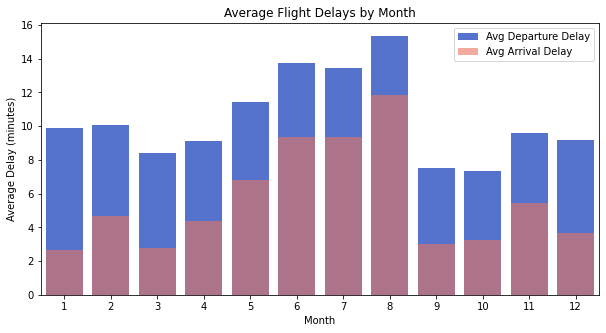

In [73]:
# Convert Spark DataFrame to Pandas
monthwise_delays_pd = monthwise_delays_sorted.toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=monthwise_delays_pd, x="Month", y="avg_dep_delay", color="royalblue", label="Avg Departure Delay")
sns.barplot(data=monthwise_delays_pd, x="Month", y="avg_arr_delay", color="tomato", alpha=0.6, label="Avg Arrival Delay")

plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.title("Average Flight Delays by Month")
plt.legend()
plt.show()


##  Weekday vs. Weekend Delays

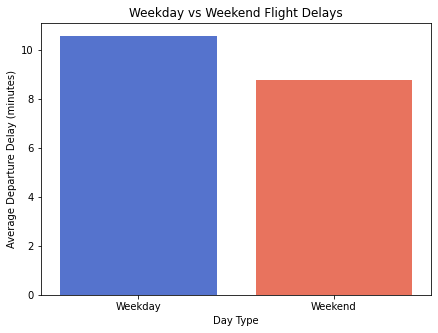

In [74]:
# Convert Spark DataFrame to Pandas
day_type_delays_pd = day_type_delays.toPandas()

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=day_type_delays_pd, x="DayType", y="avg_dep_delay", palette=["royalblue", "tomato"])

plt.xlabel("Day Type")
plt.ylabel("Average Departure Delay (minutes)")
plt.title("Weekday vs Weekend Flight Delays")
plt.show()


## Average Delay per Operating Airline

In [75]:
# Count distinct airline operators
distinct_airlines_count = df_monthly_sampled.select("Operating_Airline").distinct().count()

# Display the result
print(f"Number of distinct airline operators: {distinct_airlines_count}")


Number of distinct airline operators: 28


In [79]:
# Group by Operating_Airline and calculate average departure and arrival delays
avg_delay_per_airline = df_monthly_sampled.groupBy("Operating_Airline").agg(
    F.round(F.avg("DepDelay"), 2).alias("avg_dep_delay"),
    F.round(F.avg("ArrDelay"), 2).alias("avg_arr_delay")
)

# Convert to Pandas DataFrame for plotting
avg_delay_per_airline_pd = avg_delay_per_airline.toPandas()

avg_delay_per_airline_sorted = avg_delay_per_airline_pd.sort_values(by="avg_arr_delay", ascending=False)


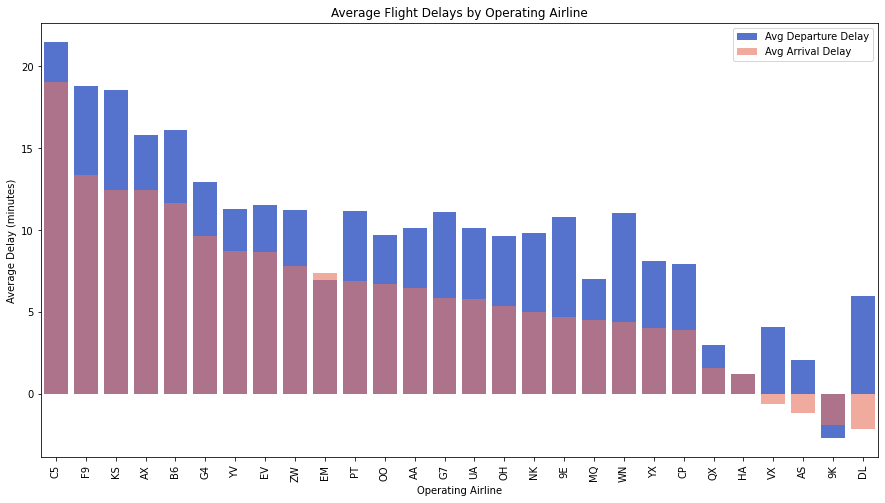

In [80]:
# Plot average delay times for both departure and arrival delays by operating airline
plt.figure(figsize=(15, 8))  # Increased figure size for a larger plot
sns.barplot(data=avg_delay_per_airline_sorted, x="Operating_Airline", y="avg_dep_delay", color="royalblue", label="Avg Departure Delay")
sns.barplot(data=avg_delay_per_airline_sorted, x="Operating_Airline", y="avg_arr_delay", color="tomato", alpha=0.6, label="Avg Arrival Delay")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
# Set plot labels and title
plt.xlabel('Operating Airline')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Flight Delays by Operating Airline')
plt.legend()
plt.show()


## Monthly Average Departure and Arrival Delays

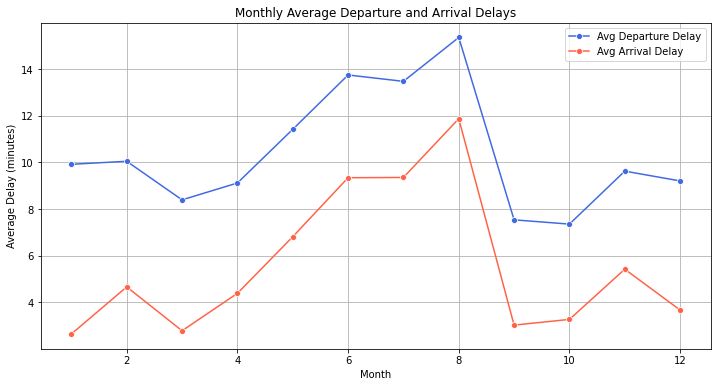

In [87]:
monthly_avg_delays = df_monthly_sampled.groupBy("Month").agg(
    F.avg("DepDelay").alias("avg_dep_delay"),
    F.avg("ArrDelay").alias("avg_arr_delay")
).toPandas()

# Sort by Month
monthly_avg_delays = monthly_avg_delays.sort_values(by="Month")

# Plot the line chart for average delays per month
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_delays, x="Month", y="avg_dep_delay", label="Avg Departure Delay", marker="o", color="royalblue")
sns.lineplot(data=monthly_avg_delays, x="Month", y="avg_arr_delay", label="Avg Arrival Delay", marker="o", color="tomato")

plt.title("Monthly Average Departure and Arrival Delays")
plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.legend()
plt.grid(True)
plt.show()

In [88]:
df_monthly_sampled.columns

['Year',
 'Quarter',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'Marketing_Airline_Network',
 'Operated_or_Branded_Code_Share_Partners',
 'DOT_ID_Marketing_Airline',
 'IATA_Code_Marketing_Airline',
 'Flight_Number_Marketing_Airline',
 'Operating_Airline',
 'DOT_ID_Operating_Airline',
 'IATA_Code_Operating_Airline',
 'Flight_Number_Operating_Airline',
 'OriginAirportID',
 'OriginAirportSeqID',
 'OriginCityMarketID',
 'Origin',
 'OriginCityName',
 'OriginState',
 'OriginStateFips',
 'OriginStateName',
 'OriginWac',
 'DestAirportID',
 'DestAirportSeqID',
 'DestCityMarketID',
 'Dest',
 'DestCityName',
 'DestState',
 'DestStateFips',
 'DestStateName',
 'DestWac',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDelayMinutes',
 'DepDel15',
 'DepartureDelayGroups',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrivalDelayGroups',
 'ArrTimeBlk',
 'Cancelled',
 'Diverted',
 'CRSElapsedTime',
 'ActualEla

## Heatmap: Correlation Matrix of Numerical Columns

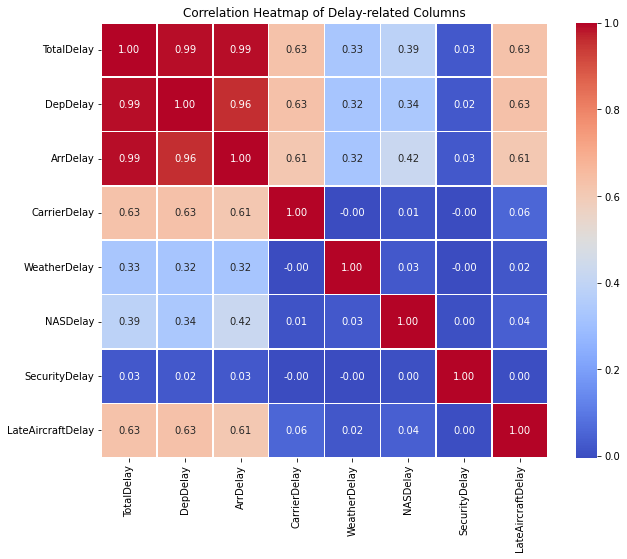

In [95]:
# Select relevant numerical columns
numerical_columns = ["TotalDelay","DepDelay", "ArrDelay", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]
df_corr = df_monthly_sampled.select(numerical_columns).toPandas()

# Compute correlation matrix
corr = df_corr.corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Delay-related Columns")
plt.show()


## Distribution of Flight Delays

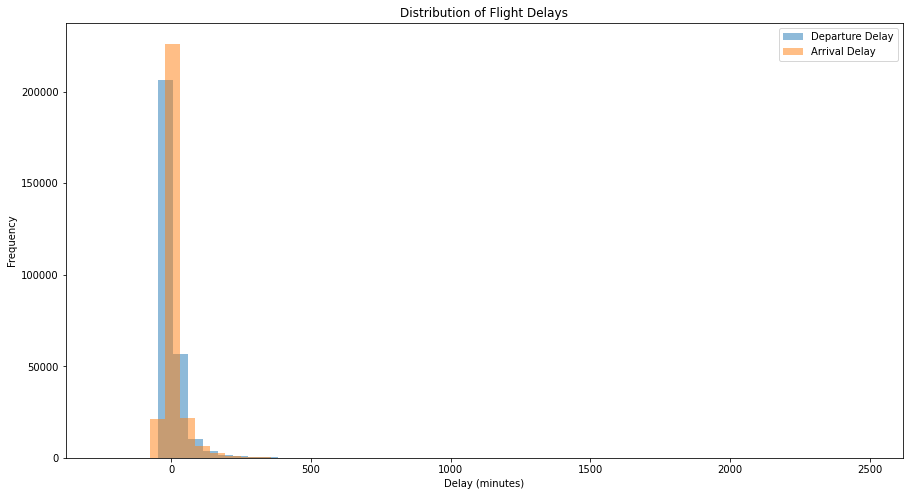

In [93]:
# Convert PySpark DataFrame to Pandas and filter out missing values
df_pandas = df_monthly_sampled.select("DepDelay", "ArrDelay").toPandas()

# Drop NaN values
df_pandas = df_pandas.dropna(subset=["DepDelay", "ArrDelay"])

# Plot histograms for both Departure and Arrival delays
plt.figure(figsize=(15, 8))
plt.hist(df_pandas["DepDelay"], bins=50, alpha=0.5, label="Departure Delay")
plt.hist(df_pandas["ArrDelay"], bins=50, alpha=0.5, label="Arrival Delay")
plt.title("Distribution of Flight Delays")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Relationship between Multiple Delay Types

<Figure size 1152x720 with 0 Axes>

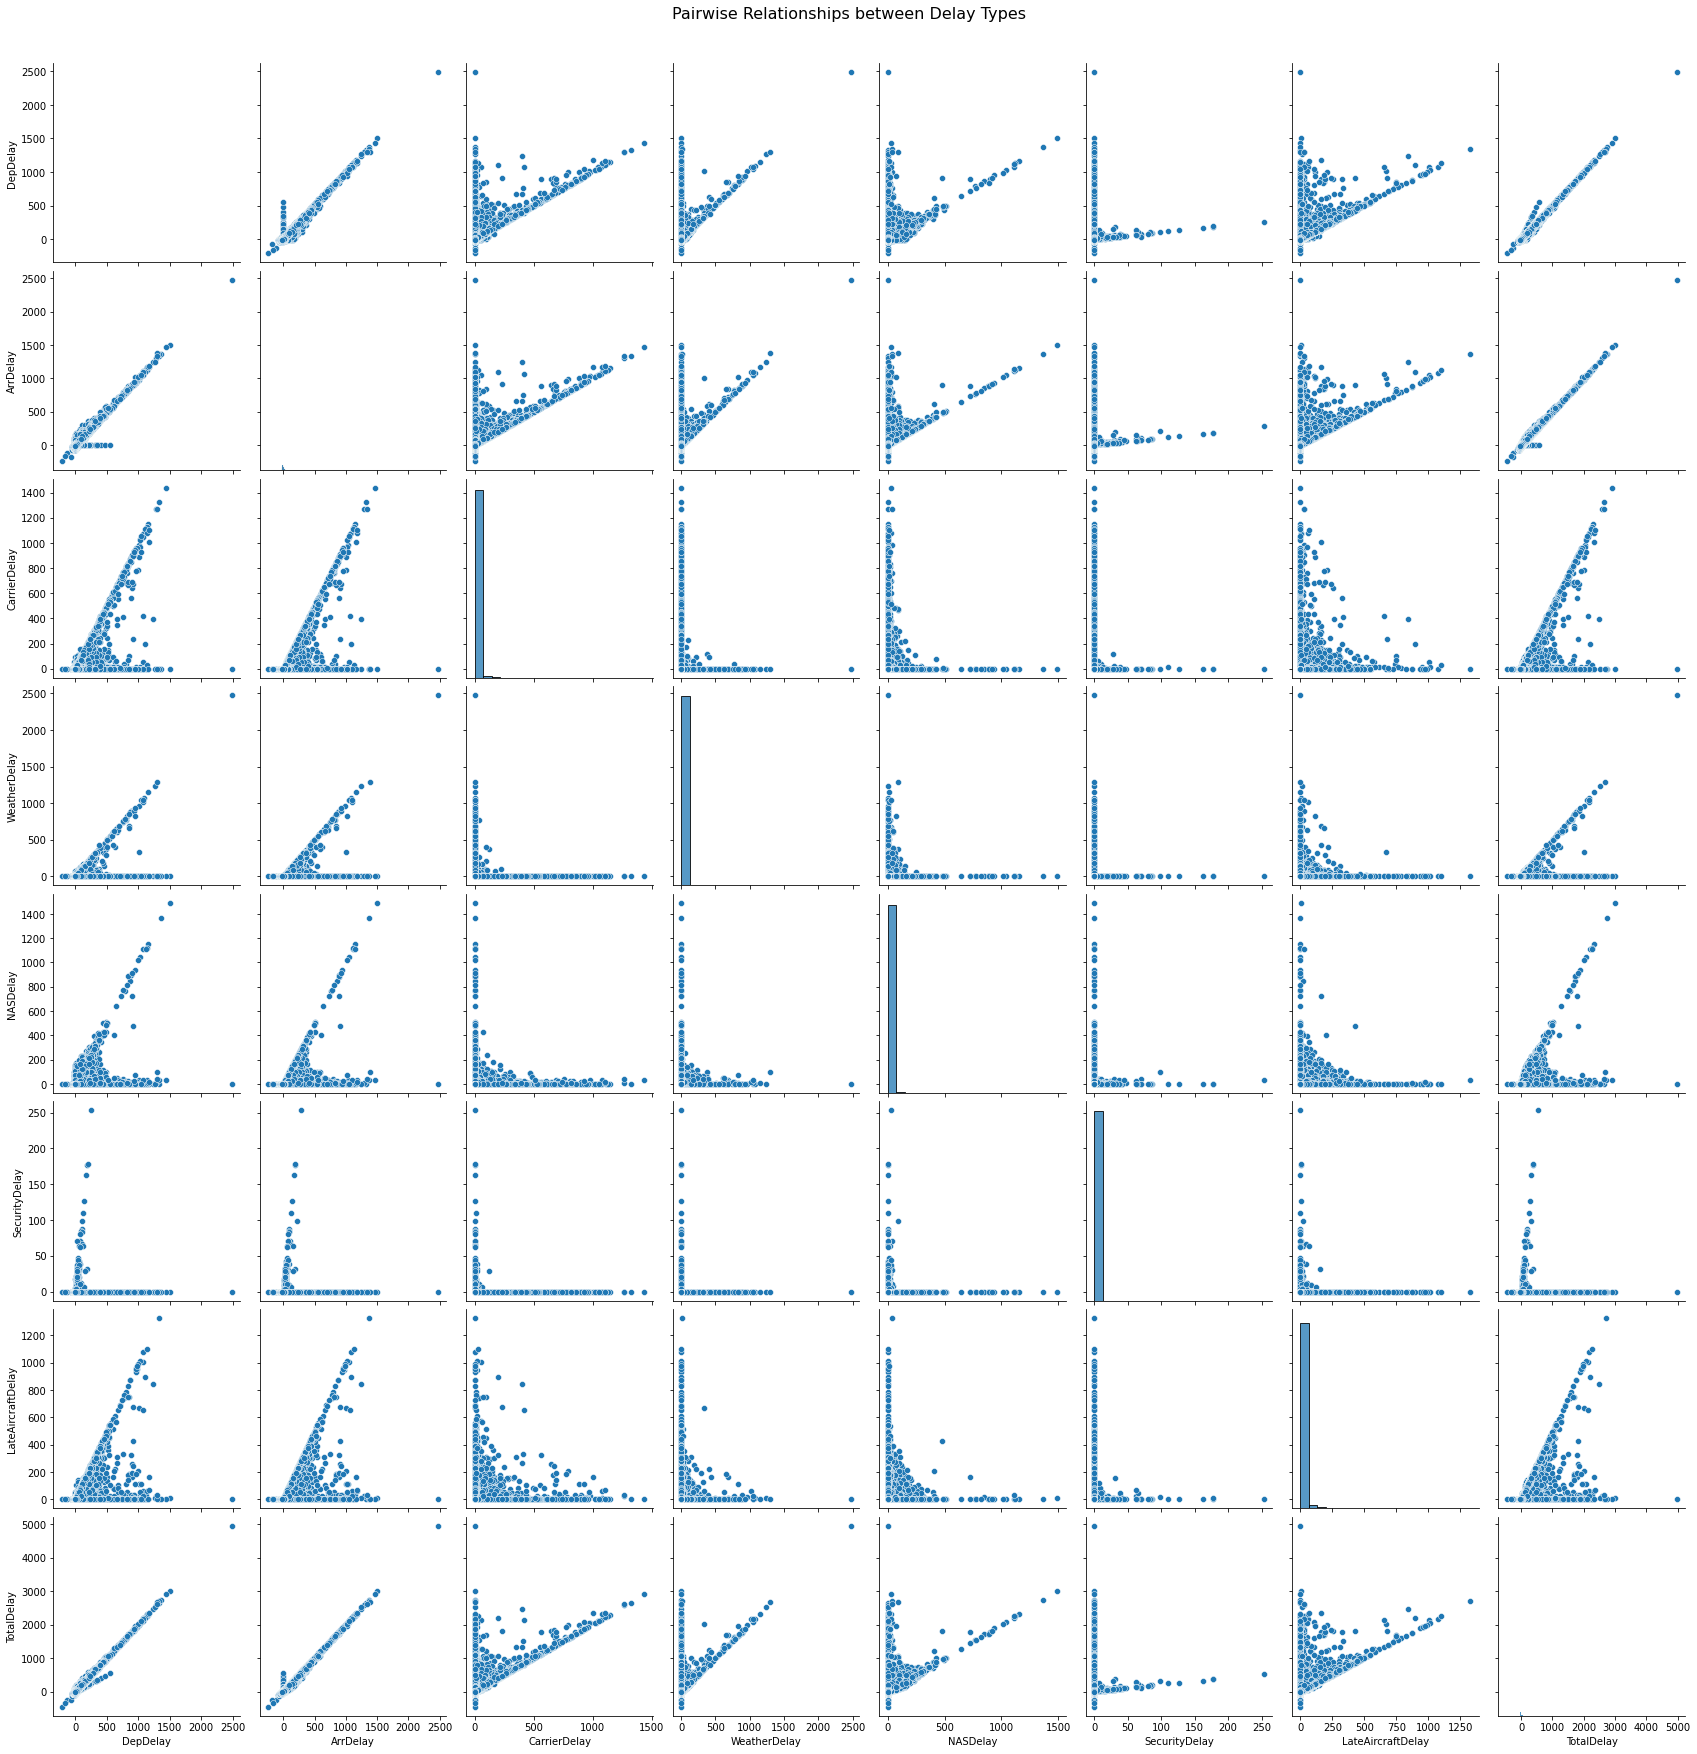

In [99]:
# Select relevant columns for pair plot
delay_columns = ["DepDelay", "ArrDelay", "CarrierDelay", "WeatherDelay","NASDelay", "SecurityDelay", "LateAircraftDelay","TotalDelay"]
df_delay_pair = df_monthly_sampled.select(delay_columns).toPandas()

# Create a larger figure and plot Pair Plot
plt.figure(figsize=(16, 10))  
sns.pairplot(df_delay_pair, height=3)  # Adjust height of individual subplots
plt.suptitle("Pairwise Relationships between Delay Types", y=1.02, fontsize=16)  # Increase title font size
plt.show()